<a href="https://colab.research.google.com/github/Louiii/ValueDecomposition/blob/main/ValueDecomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value-Decomposition Networks For Cooperative Multi-Agent Learning

https://arxiv.org/pdf/1706.05296.pdf

Specifically, the agent has:
- Value decomposition
- Shared weights (shared critic neural network)
- Role information (one-hot vector indicating which agent it is, concatenated to the observation)
- Centralisation (add each agents Q-values before optimising the weights, during training)
- (No low/high level differentiable communication)

Note: The code supports training on a GPU. However, due to the format of the training process it doesn't provide huge speed-ups. This can be improved by training less frequently- but with multiple batches from the episode memory. 

In [1]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Cloning into 'ma-gym'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 981 (delta 16), reused 32 (delta 8), pack-reused 931
Receiving objects: 100% (981/981), 3.72 MiB | 28.62 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/content/ma-gym
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
     |████████████████████████████████| 788kB 7.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 54.2.0
    Uninstalling setuptools-54.2.0:
      Successfully uninstalled setuptools-54.2.0


In [2]:
%matplotlib inline
import gym, ma_gym, glob, io, base64
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython import display as ipythondisplay
from typing import Dict, List, Tuple
from tqdm import tqdm
import sys, collections, random, numpy as np, torch
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

nn = torch.nn
F = torch.nn.functional
optim = torch.optim

SEED = 672

def set_all_seeds(seed):
  random.seed(seed)
  # os.environ('PYTHONHASHSEED') = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

class Switch:
  ''' wrapper to encode the time in the state '''
  def __init__(self, num_agents=2, vid=False):
    nm = "Switch%d-v0"%num_agents
    self.n_agents = num_agents
    self.env = wrap_env(gym.make(nm)) if vid else gym.make(nm)
    self.t, self.dt = 0, 1#0.01
    self.render, self.close = self.env.render, self.env.close
    # self.conv_state = lambda obs: [o+[self.t] for o in obs]

    self.ts = np.linspace(0, np.pi, 30)
    self.conv_state = lambda obs: [o+np.cos(self.t*self.ts).tolist() for o in obs]
    self.state_dim = len(self.ts)+2
    self.action_dim = 5
  
  def reset(self):
    return self.conv_state(self.env.reset())
  
  def step(self, a):
    obs_n, reward_n, done_n, info = self.env.step(a)
    self.t += self.dt
    if np.all(done_n): self.t = 0# switch has a max of 100 steps
    return self.conv_state(obs_n), reward_n, done_n, info

def record_ep(agents, env, maxT=100):
  obs_n = env.reset()
  env.render()
  for _ in range(maxT):
    if type(agents)==list:
      a = np.array([agent.act(state) for state, agent in zip(obs_n, agents)])
    else:
      a = agents.act(obs_n)
    obs_n, reward_n, done_n, info = env.step(a)
    env.render()
    if np.all(done_n): break
  env.close()
  show_video()

def rollout_centralised(env, agents, train=True, exploration=True, max_episode=30000, log_episode_interval=5, verbose=False):
  history_reward = []
  state_n = env.reset()
  episode_reward = 0
  episode_count = 0
  recorded_episodes = []
  recorded_episode_reward = []

  if train:
    act = lambda o_s, ex: agents.act(o_s, ex)
  else:
    act = lambda o_s, _: [a.act(o) for a, o in zip(agents, o_s)]

  while episode_count < max_episode:
    actions = act(state_n, exploration)
    next_state_n, reward_n, done_n, _ = env.step(actions)

    episode_reward += np.mean(reward_n)
    if train:
      agents.update(state_n, actions, reward_n, next_state_n, done_n)

    state_n = next_state_n
    if np.all(done_n):
      if not train:
        for a in agents: a.reset()
      state_n = env.reset()
      history_reward.append(episode_reward)
      episode_reward = 0
      episode_count += 1
      if episode_count % log_episode_interval == 0:
        recorded_episodes.append(episode_count)
        episodes_mean_reward = np.mean(history_reward)
        recorded_episode_reward.append(episodes_mean_reward)
        history_reward = []
        if verbose:
          print('Episodes {}, Reward {}'.format(episode_count, episodes_mean_reward))
  return recorded_episodes, recorded_episode_reward

def run_experiments(Envir, EnvArgs, Agent, Hyp_, 
                    n_episodes=1000, runs=10, log_interval=10, verbose=False):
  # store data for each run
  train_log = []
  train_reward_log = []
  test_reward_log = []

  pbar = tqdm(range(runs))
  for i in pbar:
    env = Envir(**EnvArgs)
    agents = Agent(*Hyp_)
    
    train_, train_reward = rollout_centralised(env=env, 
                                              agents=agents, 
                                              train=True,
                                              exploration=True, 
                                              max_episode=n_episodes,
                                              log_episode_interval=log_interval,
                                              verbose=verbose)
    print(train_reward[-1])

    # store result for every run
    train_log.append(train_)
    train_reward_log.append(train_reward)
    
    ####################################### TESTING ##############################
    separated_agents = agents.get_agents()# split the agents up
    test_, test_reward = rollout_centralised(env=Envir(**EnvArgs), 
                                             agents=separated_agents, 
                                             train=False,
                                             exploration=False, 
                                             max_episode=10, 
                                             log_episode_interval=1,
                                             verbose=verbose)
    # store result for every run
    test_reward_log.append(np.mean(test_reward))

    pbar.set_description('r train: %.4f, r test: %.5f'%(train_reward[-1], test_reward_log[-1]))
  return train_log, train_reward_log, test_reward_log, agents, separated_agents

def plot_experiments(train_log, train_reward_log, test_reward_log, runs):
  ####################################### TRAINING #######################################
  fig = plt.figure(figsize=(9, 7))
  ax = fig.add_subplot(111)

  for i in range(runs):
    ax.plot(train_log[i], train_reward_log[i], label=f'run {i+1}')
  ax.set_title(f"Train learning Curve for {runs} runs")
  ax.set_ylabel("Episodic Reward")
  ax.set_xlabel("Iterations")
  ax.legend(loc="lower right")
  plt.tight_layout()
  plt.show()

  ####################################### TESTING #######################################
  print(f'test reward (average over {runs} runs):', np.mean(test_reward_log))



class Agents:
  def __init__(self, n_actions, n_agents):
    self.act = lambda o: [np.random.randint(0,n_actions) for _ in range(n_agents)]

env = Switch(vid=True)
record_ep(Agents(env.action_dim, env.n_agents), env, maxT=100)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
set_all_seeds(SEED)
print(torch.randn(4,3))
print(np.random.uniform(0, 1, (3, 2)))
print(random.randint(0, 1000))

tensor([[-0.3507, -0.9876, -0.1086],
        [-0.4135,  1.3471,  0.7402],
        [ 1.0042,  0.4497, -1.4222],
        [ 0.0188,  0.3394,  1.0784]])
[[0.82992953 0.72628057]
 [0.76157671 0.45658561]
 [0.03910154 0.26791656]]
18


In [14]:
class EpisodeBuffer:
  def __init__(self):
    self.transitions = []

  def put(self, transition):
    self.transitions.append(transition)
  
  def sample(self, lookup_step=None, idx=None):
    tr = self.transitions
    if idx is not None: tr = tr[idx:idx+lookup_step]
    return list(map(np.array, zip(*tr)))# [T, (o,a,r,n,d), A, I] --> [(o,a,r,n,d), T, A, I]
    
  def __len__(self):
    return len(self.transitions)

class EpisodeMemory():
  def __init__(self, n_agents, batch_sample=False, max_epi_num=100, max_epi_len=500,
                      batch_size=1, lookup_step=None):
    self.n_agents = n_agents
    self.max_epi_num = max_epi_num
    self.max_epi_len = max_epi_len
    self.batch_size = batch_size
    self.lookup_step = lookup_step
    self.memory = collections.deque(maxlen=self.max_epi_num)
    self.sample = self.batch_sample if batch_sample else self.sequential_sample

  def put(self, episode):
    self.memory.append(episode)
  
  def convert(self, sample, T, device):
    # sample:  [B, (o,a,r,n,d), T, A, values] >>> (o,a,r,n,d) [A,B,T,I]
    
    # I think I have to perform this triple loop unfortunately
    D = [[[ep[i][:,j] for ep in sample] for j in range(self.n_agents)] for i in range(5)]
    o, a, r, n, d = D
    
    cv = lambda ten,dty: torch.tensor(ten, dtype=dty).reshape(self.n_agents,len(sample),T,-1).to(device)
    o, r, n, d = map(lambda x:cv(x, torch.float), [o, r, n, d])
    a = cv(a, torch.long)
    
    return o, a, r, n, d

  def sequential_sample(self, device):
    # Benefit: Whole episode update. Downside: batch-size = 1
    idx = np.random.randint(0, len(self.memory))
    episode = self.memory[idx].sample()
    return self.convert([episode], len(episode), device)

  def batch_sample(self, device):
    # Cuts off episode lengths to the minimum length / look-ahead step
    sampled_episodes = random.sample(self.memory, self.batch_size)

    T_min = min(map(len, sampled_episodes))
    min_step = min(self.max_epi_len, T_min)
    T = self.lookup_step if min_step > self.lookup_step else min_step

    sample_buffer = []
    for episode in sampled_episodes:
      idx = np.random.randint(0, len(episode)-T+1)# random subset of episode
      sample = episode.sample(lookup_step=T, idx=idx)
      sample_buffer.append(sample)
            
    return self.convert(sample_buffer, T, device)

  def __len__(self):
    return len(self.memory)

class DuelingLSTMCritic(nn.Module):
  def __init__(self, state_dim, action_dim, h = 32):
    super().__init__()
    self.device = 'cpu'
    if torch.cuda.is_available(): self.device = torch.cuda.current_device()

    self.h_dim = h
    self.act_dim = action_dim

    self.Head = nn.Sequential(nn.Linear(state_dim, h), nn.ReLU())
    self.LSTM = nn.LSTM(h, h, batch_first=True)

    self.V = nn.Sequential(nn.Linear(h, h), nn.ReLU(), nn.Linear(h, 1))
    self.A = nn.Sequential(nn.Linear(h, h), nn.ReLU(), nn.Linear(h, action_dim))
    self.to(self.device)

  def forward(self, obs, hc):
    b = type(hc)==int
    if b: hc = self.init_hidden_state(hc, True)

    x = self.Head(obs.to(self.device))
    x, hc = self.LSTM(x, hc)
    v = self.V(x)
    a = self.A(x)
    # re-center (apx) advantage
    a = a - a.mean(dim=-1, keepdim=True)

    q = v + a
    return q if b else (q, hc) # dim = action dim (i.e. it computes Q(S, A) for all A) 

  def sample_action(self, obs, hc, epsilon, exploration):
    ''' episilon greedy, for all agents, the agent dimension is 0 in obs '''
    output, hc = self(obs, hc)
    best = output.argmax(-1).detach().squeeze()
    if not exploration: return best.tolist(), hc
    A = obs.size(0)
    mask = (torch.rand(A) < epsilon).long()
    a_s = [random.randint(0,self.act_dim-1) if mask[i] else best[i].item() for i in range(A)]
    return a_s, hc

    # rndm = torch.randint(self.act_dim, (A, ))
    # ac = mask * rndm + (1-mask) * best
    # return ac.tolist(), hc

  def init_hidden_state(self, batch_size=1, training=False):
    if training is True:
      return torch.zeros([1, batch_size, self.h_dim]).to(self.device), torch.zeros([1, batch_size, self.h_dim]).to(self.device)
    else:
      return torch.zeros([1, 1, self.h_dim]).to(self.device), torch.zeros([1, 1, self.h_dim]).to(self.device)

class SingleAgent:
  ''' Only used after training '''
  def __init__(self, critic, role):
    self.role, self.critic = role, critic
    self.reset()
  
  def act(self, obs):
    ''' obs: one axis '''
    o = torch.cat([self.role, torch.FloatTensor(obs).unsqueeze(0).unsqueeze(0).to(self.critic.device)], dim=-1)
    a, self.hcs = self.critic.sample_action(o, self.hcs, 0, False)
    return a
  
  # def update(self, done):
  #   ''' necessary to reset the hidden state '''
  #   if all(done): self.reset()
  
  def reset(self):
    self.hcs = self.critic.init_hidden_state(training=False)

class CentralisedAgents:
  '''
  Vectorisation TODO:
  - update fn: q = critic(..)
  '''
  def __init__(self, hyp, state_dim, action_dim, n_agents):
    self.hyp = hyp
    self.batch_size = hyp.batch_size
    self.epsilon = hyp.eps_start
    self.critic_in, self.action_dim = state_dim+n_agents, action_dim
    self.episode_memory = EpisodeMemory(n_agents, 
                                        batch_sample=hyp.batch_sample, 
                                        max_epi_num=hyp.max_epi_num, 
                                        max_epi_len=hyp.max_epi_len, 
                                        batch_size=hyp.batch_size, 
                                        lookup_step=hyp.lookup_step)
    self.ag_ixs = list(range(n_agents)) 
    self.n_agents = n_agents

    # Create Q functions
    self.critic = DuelingLSTMCritic(self.critic_in, action_dim)
    self.critic_target = DuelingLSTMCritic(self.critic_in, action_dim)
    self.critic_target.load_state_dict(self.critic.state_dict())

    self.optimiser = optim.Adam(self.critic.parameters(), lr=hyp.learning_rate)
    self.t = 0

    # store the batched roles
    self.roles = torch.eye(n_agents).reshape(n_agents, 1, 1, n_agents).to(self.critic.device)
    self.batched_roles = self.roles.repeat(1, self.batch_size, hyp.lookup_step, 1).to(self.critic.device)
    
    self.new_episode()
  
  def get_agents(self):
    agents = []
    for i in self.ag_ixs:
      c = DuelingLSTMCritic(self.critic_in, self.action_dim)
      c.load_state_dict(self.critic.state_dict())
      agents.append(SingleAgent(c, self.roles[i]))
    return agents

  def act(self, obs, exploration=True):
    obs = torch.FloatTensor(obs).unsqueeze(1).to(self.critic.device)
    o = torch.cat((self.roles[:,0], obs), dim=-1)
    a, self.hcs = self.critic.sample_action(o, self.hcs, self.epsilon, exploration)
    return a

  def update(self, obs, a, r, obs_prime, done):
    self.t += 1
    done_mask = [float(not d) for d in done]

    self.episode_record.put([obs, a, r, obs_prime, done_mask])

    if len(self.episode_memory) >= self.hyp.min_epi_num and self.t%self.hyp.train_freq==0:
      self.train()
      if self.t % self.hyp.target_update_period == 0:# perform soft update
        for target_param, local_param in zip(self.critic_target.parameters(), self.critic.parameters()):
          target_param.data.copy_(self.hyp.tau*local_param.data + (1.0-self.hyp.tau)*target_param.data)
    
    if all(done):
      self.episode_memory.put(self.episode_record)
      self.new_episode()

  def new_episode(self):
    self.epsilon = max(self.hyp.eps_end, self.epsilon * self.hyp.eps_decay) # Linear annealing
    self.episode_record = EpisodeBuffer()
    self.hcs = self.critic.init_hidden_state(self.n_agents, True)

  def train(self):
    # Get batch from replay buffer
    (o_s, a_s, r_s, n_o_s, dones) = self.episode_memory.sample(self.critic.device)
    A,B,T,I = o_s.size()
    
    n_ = torch.cat((self.batched_roles[:,:,:T], n_o_s), dim=-1).reshape(A*B,T,-1)
    with torch.no_grad():
        q_target = self.critic_target(n_, A*B).reshape(A, B, T, -1)

    q_target_max = q_target.max(-1)[0].view(A,B,T,-1).detach()
    targets = r_s + self.hyp.gamma * q_target_max * dones
    
    o_ = torch.cat((self.batched_roles[:,:,:T], o_s), dim=-1)
    q_ = self.critic(o_.reshape(A*B,T,-1), A*B).reshape(A, B, T, -1).contiguous()
    q = q_.gather(-1, a_s).sum(0)

    loss = F.smooth_l1_loss(q, targets.sum(0))
    
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

In [10]:
set_all_seeds(SEED)

class DQRN_Hyp():
  batch_size = 16
  gamma = 0.99
  learning_rate = 2e-3
  target_update_period = 20
  train_freq = 5
  eps_start = 0.3
  eps_end = 0.001
  eps_decay = 0.995
  tau = 1e-2
  batch_sample = True
  lookup_step = 40
  min_epi_num = 20
  max_epi_len = 100 
  max_epi_num = 100

n_agents = 2
env = Switch(num_agents=n_agents)

hyp = DQRN_Hyp()
state_dim = env.state_dim
action_dim = env.action_dim

runs = 10
train_log, train_reward_log, test_reward_log, agents, separated_agents = run_experiments(Switch, 
                                                               {'num_agents':n_agents,'vid':False},
                                                               CentralisedAgents, 
                                                               [hyp, state_dim, action_dim, n_agents], 
                                                               n_episodes=1000,
                                                               runs=runs,
                                                               verbose=False)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



  0%|          | 0/10 [00:00<?, ?it/s]


r train: 3.8000, r test: 3.80000:   0%|          | 0/10 [02:30<?, ?it/s]


r train: 3.8000, r test: 3.80000:  10%|█         | 1/10 [02:30<22:33, 150.44s/it]

3.7999999999999994
-2.450000000000002





r train: -2.4500, r test: -2.45000:  10%|█         | 1/10 [07:54<22:33, 150.44s/it]


r train: -2.4500, r test: -2.45000:  20%|██        | 2/10 [07:54<26:59, 202.45s/it]




2.8999999999999995


r train: 2.9000, r test: 2.90000:  20%|██        | 2/10 [11:28<26:59, 202.45s/it]  


r train: 2.9000, r test: 2.90000:  30%|███       | 3/10 [11:28<24:02, 206.05s/it]


r train: 3.4000, r test: 3.40000:  30%|███       | 3/10 [15:09<24:02, 206.05s/it]


r train: 3.4000, r test: 3.40000:  40%|████      | 4/10 [15:09<21:02, 210.44s/it]

3.3999999999999995





r train: 3.5300, r test: 3.40000:  40%|████      | 4/10 [18:49<21:02, 210.44s/it]


r train: 3.5300, r test: 3.40000:  50%|█████     | 5/10 [18:49<17:47, 213.49s/it]

3.53





r train: 3.7000, r test: 3.70000:  50%|█████     | 5/10 [21:51<17:47, 213.49s/it]


r train: 3.7000, r test: 3.70000:  60%|██████    | 6/10 [21:51<13:35, 203.82s/it]

3.7





r train: 3.7000, r test: 3.70000:  60%|██████    | 6/10 [24:10<13:35, 203.82s/it]


r train: 3.7000, r test: 3.70000:  70%|███████   | 7/10 [24:10<09:13, 184.51s/it]

3.7000000000000006
-0.574999999999999





r train: -0.5750, r test: -5.00000:  70%|███████   | 7/10 [26:54<09:13, 184.51s/it]


r train: -0.5750, r test: -5.00000:  80%|████████  | 8/10 [26:54<05:56, 178.23s/it]


r train: 3.4000, r test: 3.40000:  80%|████████  | 8/10 [30:02<05:56, 178.23s/it]  


r train: 3.4000, r test: 3.40000:  90%|█████████ | 9/10 [30:02<03:01, 181.28s/it]

3.3999999999999995





r train: 3.6000, r test: 3.60000:  90%|█████████ | 9/10 [32:42<03:01, 181.28s/it]


r train: 3.6000, r test: 3.60000: 100%|██████████| 10/10 [32:42<00:00, 196.27s/it]

3.6


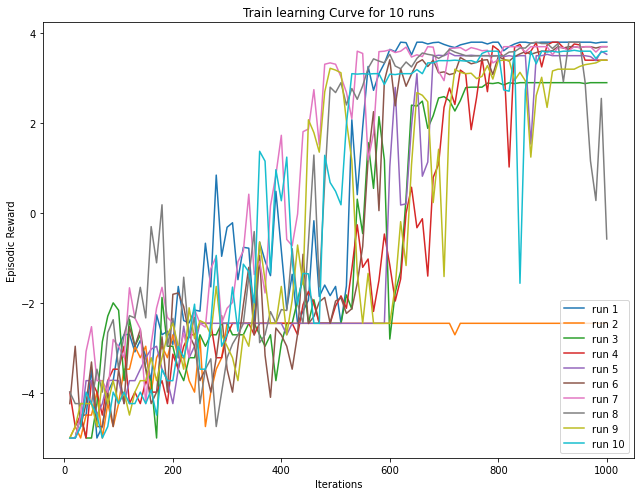

test reward (average over 10 runs): 2.045


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
plot_experiments(train_log, train_reward_log, test_reward_log, runs)

In [6]:
record_ep(agents, Switch(num_agents=n_agents, vid=True))

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
